In [1]:
import sys

sys.path.insert(0, "../source")

from data_utils import get_iterable

import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", style="whitegrid", font_scale=1.5)


In [2]:
COLORS = ["#55A868", "black", "#4C72B0"]
LABELS = ["SIF", None, "XCO$_2$"]


In [3]:
def plot_empirical_group(ids, group, ax):
    idx = np.sum(ids)
    color = COLORS[idx]
    label = LABELS[idx]
    if idx != 1:
        idx = 0  # plot semivariances on the same graph

    sns.scatterplot(
        data=group,
        x="bin_center",
        y="bin_mean",
        color=color,
        label=label,
        ax=ax[idx],
    )


def plot_model_group(ids, group, ax, legend):
    idx = np.sum(ids)
    color = COLORS[idx]
    if idx != 1:
        idx = 0  # plot semivariances on the same graph

    sns.lineplot(
        data=group,
        x="distance",
        y="variogram",
        linestyle="dashed",
        color=color,
        ax=ax[idx],
    )
    ax[idx].set_xlabel(None)
    if idx == 1:
        ax[idx].set_ylabel("Cross-semivariance")
    else:
        ax[idx].set_ylabel("Semivariance")

    if idx == 0:
        ax[idx].set_title(legend)

    if idx != 1:
        ax[idx].set_ylim(bottom=0.0, top=1.2)
        ax[idx].legend(loc="lower right", markerscale=1.5)


def plot_variograms(fit_result, axes, legend):

    groups_empirical = fit_result.df_empirical.groupby(level=[0, 1])
    for ids, df_group in groups_empirical:
        plot_empirical_group(ids, df_group, get_iterable(axes))

    groups_model = fit_result.df_theoretical.groupby(level=[0, 1])
    for ids, df_group in groups_model:
        plot_model_group(ids, df_group, get_iterable(axes), legend)


Text(0.5, 0.01, 'Separation distance (km)')

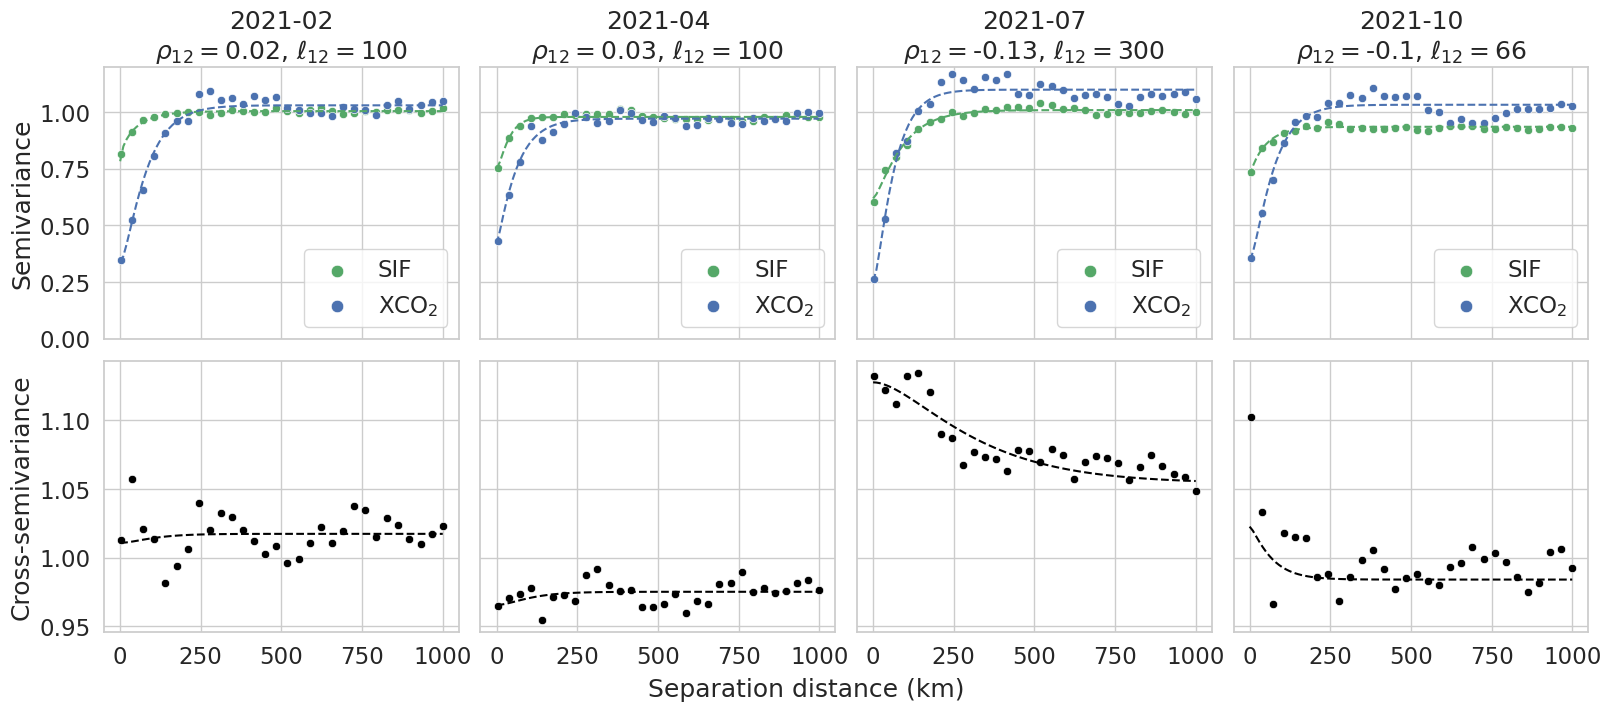

In [4]:
months = {"202102": "2021-02", "202104": "2021-04", "202107": "2021-07", "202110": "2021-10"}

fig, axes = plt.subplots(
    2, 4, figsize=(16, 7), constrained_layout=True, sharex=True, sharey="row"
)

for i, m in enumerate(months.items()):
    month, month_label = m
    with open(f"../data/intermediate/models/{month}/bivariate_model.pickle", "rb") as f:
        bivariate_matern = pickle.load(f)

    df_params = bivariate_matern.params.to_dataframe()
    cross_correlation = np.round_(
        df_params[df_params["name"] == "rho_12"]["value"].values[0], 2
    )
    length_scale = int(df_params[df_params["name"] == "len_scale_12"]["value"].values[0])
    legend = (
        f"{month_label}\n"
        + r"$\rho_{12} = $"
        + f"{cross_correlation}, "
        + r"$\ell_{12} = $"
        + f"{length_scale}"
    )

    plot_variograms(bivariate_matern.fit_result, axes[:, i], legend)

fig.supxlabel("Separation distance (km)", fontsize=18)


In [5]:
fig.savefig(f"../figures/fitted_models.pdf", dpi=300, bbox_inches="tight")
